<a href="https://colab.research.google.com/github/bernardowenzel/MVP_SPRINT_1/blob/main/MVP_Bernardo_Wenzel_Sprint_1_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Modelo de Classificação - Avaliação de decisão de compra de carro**

**Situação Hipotética**

Ronaldo trabalha como vendedor numa concessionária de carros e, como toda empresa que trabalha com vendas, precisa estar bastante atento ao atingimento das metas mensais.

Devido a preocupação e pressão de seu supervisor para o atingimento das metas, Ronaldo decidiu se preparar para melhor atender os clientes a fim de converter o maior número possível de vendas.

Com as características que conseguia acesso sobre os clientes, Ronaldo visava entender cada perfil para saber qual melhor estratégia de discurso adotar e concretizar sua venda.

Para isso, Ronaldo criou um modelo de Classificação para estimar a chance de um cliente comprar um carro com base nas características que ele possuía.

O dataset é composto de 1000 registros e 5 colunas, sendo elas:

- User ID
- Gender ("maculino" ou "feminino")
- Age
- AnnualSalary
- Purchased (dado se decidiu ou não comprar, sendo 1 para "sim" e 0 para "não".

## 1 - Importação Bibliotecas

In [ ]:
# configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

# Imports necessários
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler      ## Para padronizar os atributos
from sklearn.preprocessing import MinMaxScaler        ## Para normalizar os atributos
from sklearn import preprocessing                     ## Transformar o atributo "Sexo" em 0 e 1
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold             ## validação cruzada entre os subconjuntos criados para entender como o modelo generaliza
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score   ## validação cruzada retornando uma lista com a acurácia dos testes, métrica utilizada nesse modelo
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.feature_selection import SelectKBest # para a Seleção Univariada
from sklearn.feature_selection import f_classif # para o teste ANOVA da Seleção Univariada
from sklearn.feature_selection import RFE # para a Eliminação Recursiva de Atributos
from sklearn.linear_model import LogisticRegression # Regressão Logística, para a Eliminação Recursiva de Atributos

## 2 - Carga do Dataset e Tratamentos Básicos

In [ ]:
# Informa a URL de importação do dataset
url = "https://raw.githubusercontent.com/bernardowenzel/MVP_SPRINT_1/main/car_data.csv"

# Lê o arquivo
dataset = pd.read_csv(url, delimiter=',')

# Mostra as primeiras linhas do dataset
dataset.head()

,User ID,Gender,Age,AnnualSalary,Purchased
0,385,Male,35,20000,0
1,681,Male,40,43500,0
2,353,Male,49,74000,0
3,895,Male,40,107500,1
4,661,Male,25,79000,0


In [ ]:
# Verificando se possui algum campo com dados nulos
dataset.isnull().any()

User ID         False
Gender          False
Age             False
AnnualSalary    False
Purchased       False
dtype: bool

In [ ]:
# Alterando nome das colunas para versão traduzida
dfclientes = dataset.rename(columns={'User ID': 'ID_Cliente',
                                     'Gender': 'Sexo',
                                     'Age': 'Idade',
                                     'AnnualSalary': 'Salario_Anual',
                                     'Purchased': 'Flag_Comprou'})

df = pd.DataFrame(dfclientes)
print(df)

     ID_Cliente    Sexo  Idade  Salario_Anual  Flag_Comprou
0           385    Male     35          20000             0
1           681    Male     40          43500             0
2           353    Male     49          74000             0
3           895    Male     40         107500             1
4           661    Male     25          79000             0
..          ...     ...    ...            ...           ...
995         863    Male     38          59000             0
996         800  Female     47          23500             0
997         407  Female     28         138500             1
998         299  Female     48         134000             1
999         687  Female     44          73500             0

[1000 rows x 5 columns]


In [ ]:
# Transformando dados do campo "Sexo" em binário, onde 1 = Masculino e 0 igual a Feminino
df['Sexo'] = df['Sexo'].replace({'Male' : '1',
                                 'Female': '0'}, regex=True)

# Convertendo o formato da coluna Sexo de object para int
df['Sexo'] = df['Sexo'].astype(int)

print(df)

df.info()

     ID_Cliente  Sexo  Idade  Salario_Anual  Flag_Comprou
0           385     1     35          20000             0
1           681     1     40          43500             0
2           353     1     49          74000             0
3           895     1     40         107500             1
4           661     1     25          79000             0
..          ...   ...    ...            ...           ...
995         863     1     38          59000             0
996         800     0     47          23500             0
997         407     0     28         138500             1
998         299     0     48         134000             1
999         687     0     44          73500             0

[1000 rows x 5 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   ID_Cliente     1000 non-null   int64
 1   Sexo           1000 non-null   int64
 2   I

## 3 - Análise Exploratória Breve dos Dados

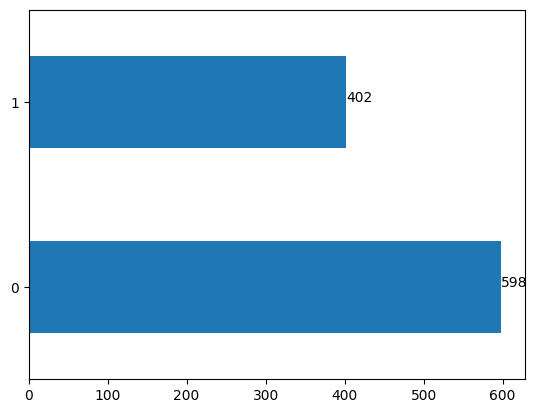

In [ ]:
# Criando gráfico de barras
df.Flag_Comprou.value_counts().plot(kind = 'barh')

# Contagem dos registros para plotar como rótulo de dados
contagem = df.Flag_Comprou.value_counts()

# Incluindo rótulos de dados no gráfico
for i, v in enumerate(contagem):
    plt.text(v, i, str(v))

# Exibir o gráfico
plt.show()

In [ ]:
# Gerando dataframe com indicadores básicos através do recurso 'describe()'
df.describe()

,ID_Cliente,Sexo,Idade,Salario_Anual,Flag_Comprou
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,500.500000,0.484000,40.106000,72689.000000,0.402000
std,288.819436,0.499994,10.707073,34488.341867,0.490547
min,1.000000,0.000000,18.000000,15000.000000,0.000000
25%,250.750000,0.000000,32.000000,46375.000000,0.000000
50%,500.500000,0.000000,40.000000,72000.000000,0.000000
75%,750.250000,1.000000,48.000000,90000.000000,1.000000
max,1000.000000,1.000000,63.000000,152500.000000,1.000000


In [ ]:
# Criando uma matriz para visualizar quantidade de registros de compra por sexo
matrix = pd.pivot_table(df, index='Sexo', columns='Flag_Comprou', aggfunc='size', fill_value=0)

# Calcular a média e a mediana do salário anual por sexo
salario_media = df.groupby('Sexo')['Salario_Anual'].mean().round(2)
salario_mediana = df.groupby('Sexo')['Salario_Anual'].median().round(2)

# Adicionando a média e mediana na matriz
matrix['Salario Média'] = salario_media
matrix['Salario Mediana'] = salario_mediana

# Exibir a matriz
print(matrix)

Flag_Comprou    0    1  Salario Média  Salario Mediana
Sexo                                                  
0             297  219       74802.33          72250.0
1             301  183       70435.95          71500.0


## 4 - Separação em conjunto de treino e conjunto de teste com holdout

In [ ]:
# eliminando id para não interferir no modelo
df = df.drop('ID_Cliente', axis = 1)

test_size = 0.20 # tamanho do conjunto de teste
seed = 7 # semente aleatória

# Separação em conjuntos de treino e teste
array = df.values
X = array[:,0:3]
y = array[:,3]

print(df)

     Sexo  Idade  Salario_Anual  Flag_Comprou
0       1     35          20000             0
1       1     40          43500             0
2       1     49          74000             0
3       1     40         107500             1
4       1     25          79000             0
..    ...    ...            ...           ...
995     1     38          59000             0
996     0     47          23500             0
997     0     28         138500             1
998     0     48         134000             1
999     0     44          73500             0

[1000 rows x 4 columns]


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=test_size, shuffle=True, random_state=seed, stratify=y) # holdout com estratificação

# Parâmetros e partições da validação cruzada
scoring = 'accuracy'
num_particoes = 10
kfold = StratifiedKFold(n_splits=num_particoes, shuffle=True, random_state=seed) # validação cruzada com estratificação


## 5 - Criação e Avaliação de Modelos

LR: 0.600000 (0.026220)
KNN: 0.815000 (0.031024)
CART: 0.887500 (0.034911)
NB: 0.885000 (0.027839)
SVM: 0.753750 (0.028532)
Bagging: 0.917500 (0.029155)
RF: 0.911250 (0.032331)
ET: 0.903750 (0.034483)
Ada: 0.890000 (0.028395)
GB: 0.912500 (0.036228)
Voting: 0.743750 (0.028641)


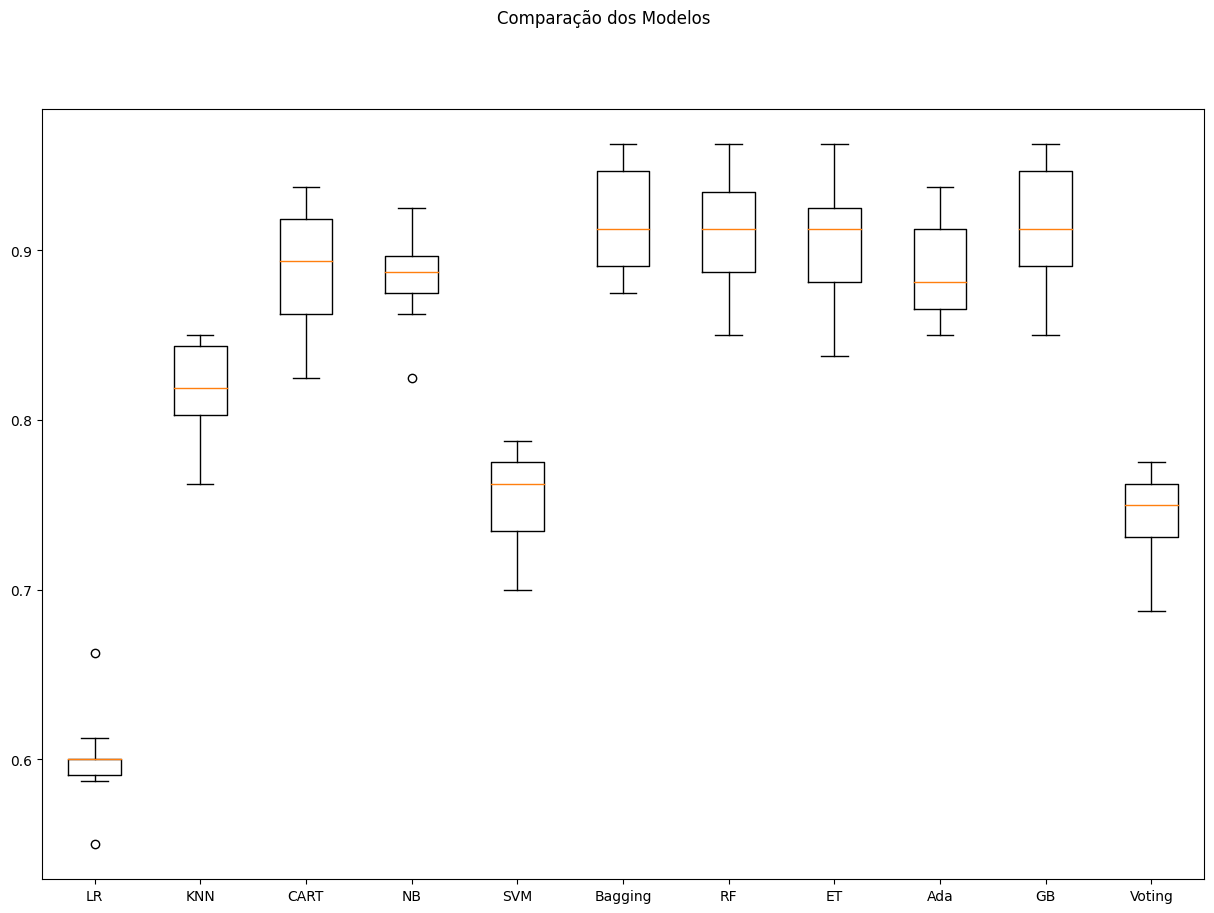

In [ ]:
np.random.seed(7) # definindo uma semente global

# Lista que armazenará os modelos
models = []

# Criando os modelos e adicionando-os na lista de modelos
models.append(('LR', LogisticRegression(max_iter=200)))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

# Definindo os parâmetros do classificador base para o BaggingClassifier
base = DecisionTreeClassifier()
num_trees = 100
max_features = 3

# Criando os modelos para o VotingClassifier
bases = []
model1 = LogisticRegression(max_iter=200)
bases.append(('logistic', model1))
model2 = DecisionTreeClassifier()
bases.append(('cart', model2))
model3 = SVC()
bases.append(('svm', model3))

# Criando os ensembles e adicionando-os na lista de modelos
models.append(('Bagging', BaggingClassifier(base_estimator=base, n_estimators=num_trees)))
models.append(('RF', RandomForestClassifier(n_estimators=num_trees, max_features=max_features)))
models.append(('ET', ExtraTreesClassifier(n_estimators=num_trees, max_features=max_features)))
models.append(('Ada', AdaBoostClassifier(n_estimators=num_trees)))
models.append(('GB', GradientBoostingClassifier(n_estimators=num_trees)))
models.append(('Voting', VotingClassifier(bases)))

# Listas para armazenar os resultados
results = []
names = []

# Avaliação dos modelos
for name, model in models:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(15,10))
fig.suptitle('Comparação dos Modelos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

Pode-se reparar que nessa etapa o melhor modelo é o Bagging

## 6 - Criação e avaliação de modelos: dados padronizados e normalizados

LR-orig: 0.600 (0.026)
KNN-orig: 0.815 (0.031)
CART-orig: 0.887 (0.035)
NB-orig: 0.885 (0.028)
SVM-orig: 0.754 (0.029)
Bag-orig: 0.918 (0.029)
RF-orig: 0.911 (0.032)
ET-orig: 0.904 (0.034)
Ada-orig: 0.890 (0.028)
GB-orig: 0.912 (0.036)
Vot-orig: 0.744 (0.029)
LR-padr: 0.828 (0.037)
KNN-padr: 0.910 (0.037)
CART-padr: 0.889 (0.029)
NB-padr: 0.884 (0.032)
SVM-padr: 0.901 (0.029)
Bag-padr: 0.915 (0.033)
RF-padr: 0.907 (0.037)
ET-padr: 0.905 (0.040)
Ada-padr: 0.890 (0.028)
GB-padr: 0.912 (0.036)
Vot-padr: 0.894 (0.031)
LR-norm: 0.820 (0.037)
KNN-norm: 0.911 (0.037)
CART-norm: 0.891 (0.026)
NB-norm: 0.884 (0.032)
SVM-norm: 0.900 (0.034)
Bag-norm: 0.911 (0.037)
RF-norm: 0.915 (0.028)
ET-norm: 0.903 (0.039)
Ada-norm: 0.890 (0.028)
GB-norm: 0.912 (0.036)
Vot-norm: 0.892 (0.032)


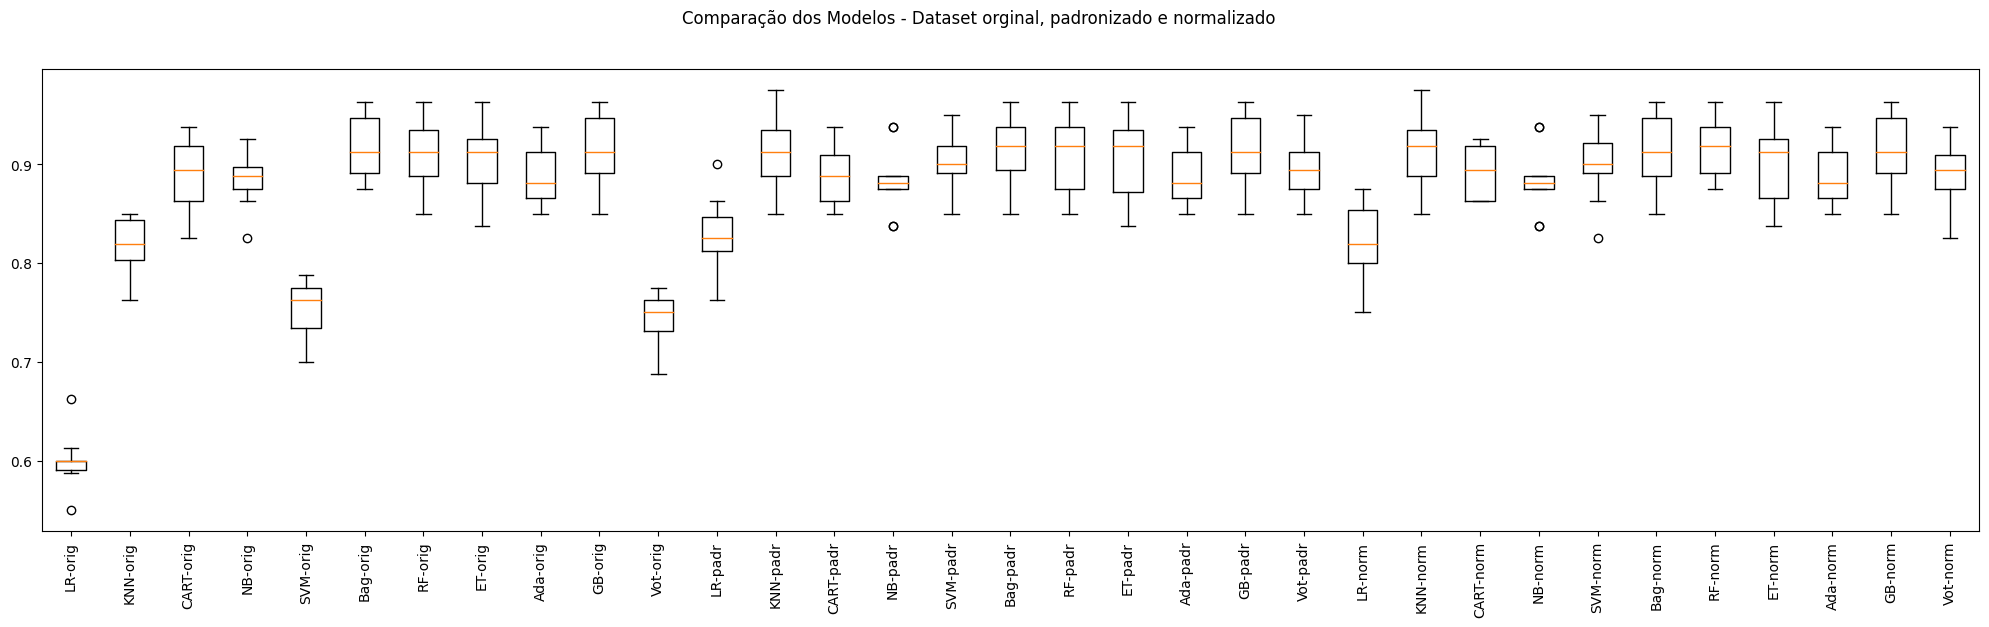

In [ ]:
np.random.seed(7) # semente global

# Listas para armazenar os armazenar os pipelines e os resultados para todas as visões do dataset
pipelines = []
results = []
names = []


# Criando os elementos do pipeline

# Algoritmos que serão utilizados
reg_log = ('LR', LogisticRegression(max_iter=200))
knn = ('KNN', KNeighborsClassifier())
cart = ('CART', DecisionTreeClassifier())
naive_bayes = ('NB', GaussianNB())
svm = ('SVM', SVC())
bagging = ('Bag', BaggingClassifier(base_estimator=base, n_estimators=num_trees))
random_forest = ('RF', RandomForestClassifier(n_estimators=num_trees, max_features=max_features))
extra_trees = ('ET', ExtraTreesClassifier(n_estimators=num_trees, max_features=max_features))
adaboost = ('Ada', AdaBoostClassifier(n_estimators=num_trees))
gradient_boosting = ('GB', GradientBoostingClassifier(n_estimators=num_trees))
voting = ('Voting', VotingClassifier(bases))

# Transformações que serão utilizadas
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())


# Montando os pipelines

# Dataset original
pipelines.append(('LR-orig', Pipeline([reg_log])))
pipelines.append(('KNN-orig', Pipeline([knn])))
pipelines.append(('CART-orig', Pipeline([cart])))
pipelines.append(('NB-orig', Pipeline([naive_bayes])))
pipelines.append(('SVM-orig', Pipeline([svm])))
pipelines.append(('Bag-orig', Pipeline([bagging])))
pipelines.append(('RF-orig', Pipeline([random_forest])))
pipelines.append(('ET-orig', Pipeline([extra_trees])))
pipelines.append(('Ada-orig', Pipeline([adaboost])))
pipelines.append(('GB-orig', Pipeline([gradient_boosting])))
pipelines.append(('Vot-orig', Pipeline([voting])))

# Dataset Padronizado
pipelines.append(('LR-padr', Pipeline([standard_scaler, reg_log])))
pipelines.append(('KNN-padr', Pipeline([standard_scaler, knn])))
pipelines.append(('CART-padr', Pipeline([standard_scaler, cart])))
pipelines.append(('NB-padr', Pipeline([standard_scaler, naive_bayes])))
pipelines.append(('SVM-padr', Pipeline([standard_scaler, svm])))
pipelines.append(('Bag-padr', Pipeline([standard_scaler, bagging])))
pipelines.append(('RF-padr', Pipeline([standard_scaler, random_forest])))
pipelines.append(('ET-padr', Pipeline([standard_scaler, extra_trees])))
pipelines.append(('Ada-padr', Pipeline([standard_scaler, adaboost])))
pipelines.append(('GB-padr', Pipeline([standard_scaler, gradient_boosting])))
pipelines.append(('Vot-padr', Pipeline([standard_scaler, voting])))

# Dataset Normalizado
pipelines.append(('LR-norm', Pipeline([min_max_scaler, reg_log])))
pipelines.append(('KNN-norm', Pipeline([min_max_scaler, knn])))
pipelines.append(('CART-norm', Pipeline([min_max_scaler, cart])))
pipelines.append(('NB-norm', Pipeline([min_max_scaler, naive_bayes])))
pipelines.append(('SVM-norm', Pipeline([min_max_scaler, svm])))
pipelines.append(('Bag-norm', Pipeline([min_max_scaler, bagging])))
pipelines.append(('RF-norm', Pipeline([min_max_scaler, random_forest])))
pipelines.append(('ET-norm', Pipeline([min_max_scaler, extra_trees])))
pipelines.append(('Ada-norm', Pipeline([min_max_scaler, adaboost])))
pipelines.append(('GB-norm', Pipeline([min_max_scaler, gradient_boosting])))
pipelines.append(('Vot-norm', Pipeline([min_max_scaler, voting])))

# Executando os pipelines
for name, model in pipelines:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %.3f (%.3f)" % (name, cv_results.mean(), cv_results.std()) # formatando para 3 casas decimais
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(25,6))
fig.suptitle('Comparação dos Modelos - Dataset orginal, padronizado e normalizado')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names, rotation=90)
plt.show()

Após a normalização e padronização, pode-se notar novamente que o melhor modelo continua sendo o Bagging, porém com os dados originais.

## 7 - Otimização dos Hiperparâmetros

In [ ]:
# Tuning do Bagging

np.random.seed(7) # definindo uma semente global para este bloco

pipelines = []

# Definindo os componentes do pipeline
bagging =  BaggingClassifier()
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

pipelines.append(('Bag-orig', Pipeline(steps=[bagging])))
pipelines.append(('Bag-padr', Pipeline(steps=[standard_scaler, bagging])))
pipelines.append(('Bag-norm', Pipeline(steps=[min_max_scaler, bagging])))

param_grid = {
    'n_estimators': [30, 50, 70, 100, 110, 130],
    'max_features': [3, 5, 7, 9, 11]
}

# Prepara e executa o GridSearchCV
for name, model in pipelines:
    grid = GridSearchCV(estimator=bagging, param_grid=param_grid, scoring=scoring, cv=kfold)
    grid.fit(X_train, y_train)
    # imprime a melhor configuração
    print("Sem tratamento de missings: %s - Melhor: %f usando %s" % (name, grid.best_score_, grid.best_params_))



Sem tratamento de missings: Bag-orig - Melhor: 0.916250 usando {'max_features': 3, 'n_estimators': 50}
Sem tratamento de missings: Bag-padr - Melhor: 0.920000 usando {'max_features': 3, 'n_estimators': 70}
Sem tratamento de missings: Bag-norm - Melhor: 0.913750 usando {'max_features': 3, 'n_estimators': 50}


Após a otimização, nota-se que o melhor modelo é o Bagging padronizado, contemplando 3 atributos e 70 classificadores base.

## 8 - Avaliação do Modelo Aplicado (Matriz de Confusão)

In [ ]:
## Treinando para testar matriz de confusão

bag_confusao = BaggingClassifier(base_estimator=base, n_estimators=num_trees)

bag_confusao.fit(X_train, y_train)

y_confusao_pred = bag_confusao.predict(X_test)

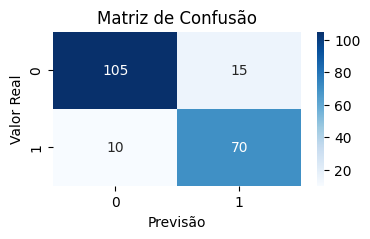

              precision    recall  f1-score   support

           0       0.91      0.88      0.89       120
           1       0.82      0.88      0.85        80

    accuracy                           0.88       200
   macro avg       0.87      0.88      0.87       200
weighted avg       0.88      0.88      0.88       200



In [ ]:

from sklearn.metrics._plot.confusion_matrix import ConfusionMatrixDisplay
import seaborn as sns
from sklearn.metrics import classification_report

confusao = confusion_matrix(y_test, y_confusao_pred)

plt.figure(figsize=(4, 2))
sns.heatmap(confusao, annot=True, cmap="Blues", fmt="d", cbar=True)
plt.title("Matriz de Confusão")
plt.xlabel("Previsão")
plt.ylabel("Valor Real")
plt.show()

classification_rep = classification_report(y_test, y_confusao_pred)

print(classification_rep)

Pelos resultados da Matriz de Confusão, é possível extrair alguns insights relevantes para o que Ronaldo precisa.

Nota-se que a precisão para a classe 0 ("Não comprou") foi o maior resultado. Dessa forma, Ronaldo consegue medir melhor os esforços empregados na venda para os clientes que não vão concretizar a compra, evitando esforço desnecessário.

Já sob a ótica do Recall, o resultado foi o mesmo para as duas classes. Portanto, o ideal seria a redução de Falsos Negativos para aproximar o resultado de 1.

Aplicando essa análise na prática, é possível chegar a duas conclusões: Ronaldo deve identificar que fatores em sua forma de vender podem ter influenciado aquele cliente a comprar, mesmo que o modelo tenha previsto a não compra. E atentar-se para não deixar que a predição modelo interfira previamente em sua abordagem ao cliente.

## 9 - Finalização do Modelo

In [ ]:
# Avaliação do modelo com o conjunto de testes

# Preparação do modelo
model = BaggingClassifier(base_estimator = DecisionTreeClassifier(), n_estimators=70, max_features = 3)
model.fit(X_train, y_train)

# Estimativa da acurácia no conjunto de teste
predictions = model.predict(X_test)
print(accuracy_score(y_test, predictions))


0.885


In [ ]:
# Preparação do modelo com TODO o dataset
model.fit(X, y)

BaggingClassifier(base_estimator=DecisionTreeClassifier(), max_features=3,
                  n_estimators=70)

## 10 - Considerações Finais

O modelo foi criado em cima de um dataset pequeno, com apenas 3 atributos e 1 target. Esse foi o fator determinante para, nesse caso específico, a não aplicação do processo de Feature Selection.

Por ser uma base pequena, foi aplicada a validação para evitar underfitting do modelo e porque o dataset estava desbalanceado.

O modelo retornou uma acurácia de 0,885 através do uso do algoritmo Bagging com as árvores de decisão.

Com as informações da Matriz de Confusão e acurácia do modelo, Ronaldo consegue entender melhor como abordar cada cliente a fim de converter o maior número possível de vendas e atingir sua meta.